In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from scipy.stats import norm
import matplotlib.lines as mlines
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from config import ORDER, JOURNAL_MAP

plt.rcParams["font.family"] = "Arial"
plt.rcParams['legend.title_fontsize'] = 7
plt.rcParams["text.usetex"] = True

df_sample = pd.read_csv("../data/focal_papers.csv")
df_generated = pd.read_csv("../data/generated_references.csv")
df_ground_truth = pd.read_csv("../data/ground_truth_references.csv")

# existing vs non-existent
df_existing = df_generated[df_generated["Exists"] == 1.0]
df_non_existent = df_generated[df_generated["Exists"] == 0.0]

/var/folders/kq/bwvwl1hd4g12lmk871x7q_br0000gn/T/ipykernel_32543/2153734850.py:18: DtypeWarning: Columns (4,68) have mixed types. Specify dtype option on import or set low_memory=False.
  df_generated = pd.read_csv("../data/generated_references.csv")


In [ ]:
# additional computations

# existence rate
references_existence_rate_per_field = df_generated.groupby(
    "top_field"
)["Exists"].mean()
references_existence_rate_per_field = references_existence_rate_per_field[ORDER]

existing_citations_per_field = df_existing.groupby(
    "top_field"
)["Citations"].median()
groundtruth_citations_per_field = df_ground_truth.groupby(
    "top_field"
)["Citation_Count_x"].median()

# references
existing_references_per_field = df_existing.groupby(
    "top_field"
)["References"].median()
groundtruth_references_per_field = df_ground_truth.groupby(
    "top_field"
)["Reference_Count_x"].median()

# reorder
existing_citations_per_field = existing_citations_per_field[ORDER]
groundtruth_citations_per_field = groundtruth_citations_per_field[ORDER]
existing_references_per_field = existing_references_per_field[ORDER]
groundtruth_references_per_field = groundtruth_references_per_field[ORDER]

n_map = df_generated.groupby("id")["Exists"].sum().to_dict()
df_sorted = df_ground_truth.sort_values(
    ['Citing_PaperID', 'Citation_Count_x'],
    ascending=[True, False]
).reset_index(drop=True)
df_kept = df_sorted.groupby("Citing_PaperID").apply(
    lambda x: x.head(int(n_map.get(x.name, 0)))
).reset_index(drop=True)
df_kept_citations_per_field = df_kept.groupby(
    "top_field"
)["Citation_Count_x"].median()
df_kept_citations_per_field = df_kept_citations_per_field[ORDER]

df_generated["type"] = "generated"
df_ground_truth["type"] = "ground_truth"

gen_cites = df_generated[["top_field", "Citations", "type"]].sort_values(["top_field"])
gt_cites = df_ground_truth[["top_field", "Citation_Count_x", "type"]].sort_values(["top_field"])
gt_cites = gt_cites.rename(columns={"Citation_Count_x": "Citations"})

combined_citations = pd.concat([gen_cites, gt_cites]).reset_index(drop=True)

combined_citations['top_field'] = pd.Categorical(
    combined_citations['top_field'],
    categories=ORDER,
    ordered=True,
)
combined_citations = combined_citations.sort_values('top_field')

/var/folders/kq/bwvwl1hd4g12lmk871x7q_br0000gn/T/ipykernel_32543/944551716.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_kept = df_sorted.groupby("Citing_PaperID").apply(


/Users/andresalgaba/Library/CloudStorage/Dropbox/Mac/github/LLMs_scientific_literature/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Text(-0.065, 0.985, '\\textbf{b}')

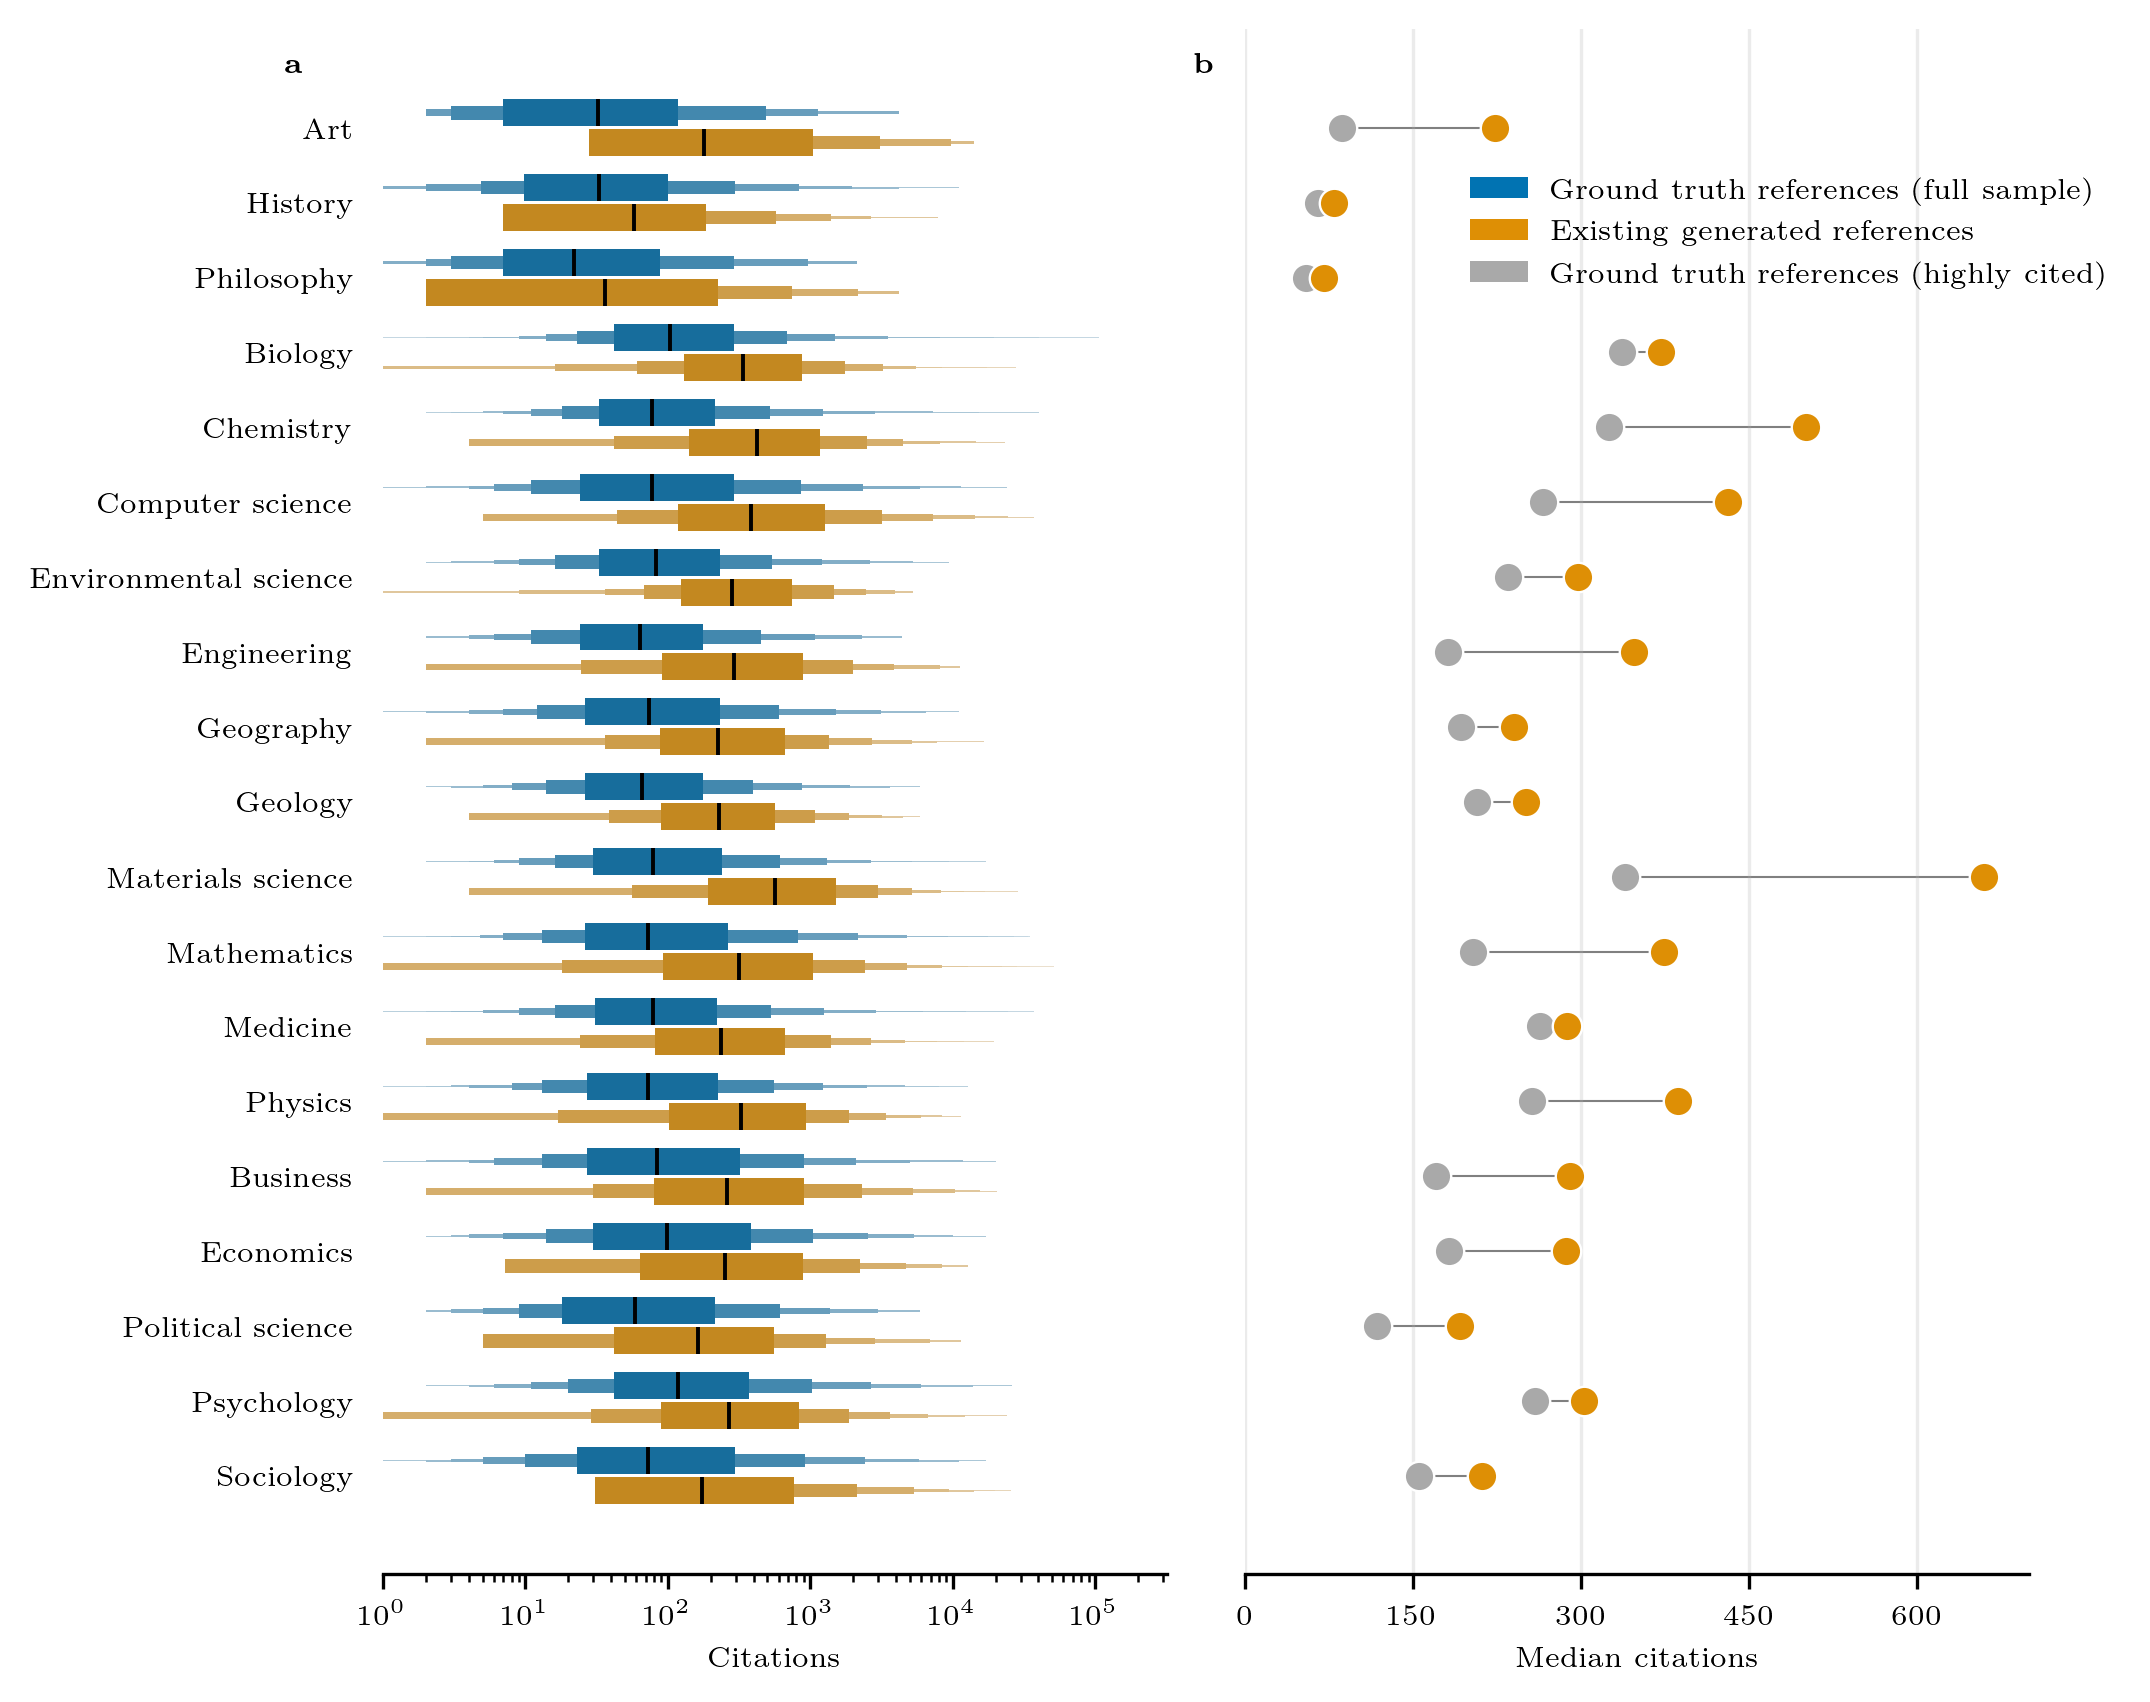

In [5]:
# appendix figure
Figure2, ax2 = plt.subplot_mosaic(
    [
        ['A', 'B'],
    ],
    figsize=(7.08, 6.69),
    dpi=300,
    gridspec_kw={'wspace': 0.1, 'hspace': 0.1},  # Adjust spacing
)

ax2['B'].sharey(ax2['A'])

# A
sns.boxenplot(
    data=combined_citations,
    x="Citations", 
    y="top_field",
    hue="type",
    hue_order=["ground_truth", "generated"],
    palette=["#0173b2", "#de8f05"],
    gap=0.1,
    log_scale=True,
    edgecolor=None,
    linecolor='black',
    showfliers=False,
    legend=False,
    ax=ax2['A'],
)

ax2["A"].tick_params(left=False)

ax2["A"].set_xlim(1, 320000)
ax2["A"].set_xlabel("Citations", fontsize=7)
ax2["A"].set_ylabel("", fontsize=7)
ax2["A"].set_xticks(
    ticks=[1, 10, 100, 1000, 10000, 100000],
    labels=[r"$10^0$", r"$10^1$", "$10^2$", "$10^3$", "$10^4$", "$10^5$"],
    fontsize=7
)
ax2["A"].set_yticks(
    ticks=list(range(references_existence_rate_per_field.index.size)),
)
ax2["A"].set_yticklabels(
    labels=[],
    fontsize=7,
)

sns.despine(ax=ax2["A"],left=True, bottom=False)

# B
sns.scatterplot(
    x=df_kept_citations_per_field.values,
    y=df_kept_citations_per_field.index,
    color="darkgray",
    s=50,
    zorder=2,
    ax=ax2["B"],
)

sns.scatterplot(
    x=existing_citations_per_field.values,
    y=existing_citations_per_field.index,
    color="#de8f05",
    s=50,
    zorder=2,
    ax=ax2["B"],
)

for i in range(len(existing_citations_per_field)):
    sns.lineplot(
        x=[
            existing_citations_per_field.iloc[i],
            df_kept_citations_per_field.iloc[i]
        ],
        y=[i, i],
        color='#808080',
        linewidth=0.5,
        zorder=1,
        ax=ax2["B"],
    )

ax2["B"].tick_params(left=False)

ax2["B"].set_xlabel("Median citations", fontsize=7)
ax2["B"].set(xlim=(0, 700))
ax2["B"].set_ylabel("", fontsize=7)
ax2["B"].set_yticks(
    ticks=list(range(references_existence_rate_per_field.index.size)),
)
ax2["B"].set_yticklabels(
    labels=[],
    fontsize=7,
)
ax2["B"].set_xticks(
    [0,150,300,450,600],
    labels=[r"0",r"150",r"300",r"450",r"600"],
    fontsize=7,
)
ax2["B"].set_title("")

ax2["B"].grid(alpha=0.25)
ax2["B"].grid(False)
ax2["B"].grid(axis='x')

sns.despine(ax=ax2["B"],left=True, bottom=False)

# ticks
ax2["A"].set_yticks(
    ticks=list(range(len(ORDER))),
)
ax2["A"].set_yticklabels(
    labels=ORDER,
    fontsize=7,
)

ax2["B"].tick_params(labelleft=False)

# legend
legend_elements = [
    Patch(facecolor='#0173b2', edgecolor=None, label='Ground truth references (full sample)'),
    Patch(facecolor='#de8f05', edgecolor=None, label='Existing generated references'),
    Patch(facecolor='darkgray', edgecolor=None, label='Ground truth references (highly cited)'),
]

ax2["B"].legend(
    handles=legend_elements,
    loc='upper right',
    title='',
    title_fontsize=7,
    fontsize=7,
    frameon=False,
    bbox_transform=Figure2.transFigure,
    bbox_to_anchor=(0.95, 0.82),
)

# annotations
ax2["A"].text(-0.125, 0.985, r"\textbf{a}", transform=ax2["A"].transAxes, 
        fontsize=7, fontweight='bold', va='top', ha='left')
ax2["B"].text(-0.065, 0.985, r"\textbf{b}", transform=ax2["B"].transAxes, 
        fontsize=7, fontweight='bold', va='top', ha='left')